In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd

# Import MTeams.csv
teams_df = pd.read_csv("MTeams.csv")

# Import MSeasons.csv
seasons_df = pd.read_csv("MSeasons.csv")

# Import MNCAATourneySeeds.csv
seeds_df = pd.read_csv("MNCAATourneySeeds.csv")

# Import MRegularSeasonCompactResults.csv
compact_results_df = pd.read_csv("MRegularSeasonCompactResults.csv")

# Import MRegularSeasonDetailedResults.csv
detailed_results_regular_df = pd.read_csv("MRegularSeasonDetailedResults.csv")

detailed_results_tourney_df = pd.read_csv("MNCAATourneyDetailedResults.csv")
# Import MMasseyOrdinals.csv
massey_ordinals_df = pd.read_csv("MMasseyOrdinals.csv")

# Import MTeamCoaches.csv
team_coaches_df = pd.read_csv("MTeamCoaches.csv")

In [21]:
detailed_results_tourney_df[detailed_results_tourney_df.Season == 2023]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
1248,2023,134,1338,60,1280,59,N,0,21,54,...,23,5,7,14,28,14,14,1,4,18
1249,2023,134,1394,75,1369,71,N,0,22,57,...,26,9,20,6,22,17,12,11,2,31
1250,2023,135,1113,98,1305,73,N,0,35,55,...,21,12,14,5,18,19,11,3,0,18
1251,2023,135,1192,84,1411,61,N,0,23,46,...,17,8,9,8,19,16,14,8,0,24
1252,2023,136,1104,96,1394,75,N,0,33,70,...,20,16,18,11,23,8,6,4,3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,1274,88,1400,81,N,0,29,49,...,25,11,15,9,14,20,13,6,1,23
1311,2023,146,1361,57,1166,56,N,0,25,66,...,17,10,11,8,24,9,9,3,2,11
1312,2023,152,1163,72,1274,59,N,0,28,57,...,20,12,12,12,17,10,9,8,1,12
1313,2023,152,1361,72,1194,71,N,0,25,57,...,22,16,21,7,24,6,9,6,2,17


Let us understand the impact of well renowned coaches on the wins of the team. 

In [3]:
indiana_team_id = teams_df.loc[
    teams_df["TeamName"].str.contains("Indiana"), "TeamID"
].values[0]


print(indiana_team_id)

1231


In [4]:
team_name = teams_df.loc[teams_df["TeamID"] == indiana_team_id, "TeamName"].values[0]
print(team_name)

Indiana


In [5]:
indiana_coaches_df = team_coaches_df[team_coaches_df["TeamID"] == 1231]

In [7]:
indiana_results_df = detailed_results_regular_df[
    (detailed_results_regular_df["WTeamID"] == 1231)
    | (detailed_results_regular_df["LTeamID"] == 1231)
]

In [10]:
combined_df = indiana_results_df.merge(
    indiana_coaches_df[["Season", "CoachName"]], on="Season", how="left"
)

## Understanding the Coach Winning Percentage for Team Indiana

In [12]:
combined_df["CoachName"].value_counts()

CoachName
tom_crean         289
archie_miller     122
mike_davis        118
mike_woodson       99
kelvin_sampson     62
dan_dakich         32
Name: count, dtype: int64

In [13]:
combined_df[combined_df["WTeamID"] == 1231]["CoachName"].value_counts()

CoachName
tom_crean         159
mike_davis         67
archie_miller      65
mike_woodson       61
kelvin_sampson     45
dan_dakich         25
Name: count, dtype: int64

In [14]:
combined_df[combined_df["LTeamID"] == 1231]["CoachName"].value_counts()

CoachName
tom_crean         130
archie_miller      57
mike_davis         51
mike_woodson       38
kelvin_sampson     17
dan_dakich          7
Name: count, dtype: int64

In [11]:
coach_stats = combined_df.groupby("CoachName").apply(
    lambda x: (x["WTeamID"] == 1231).mean()
)

In [12]:
coach_stats

CoachName
archie_miller     0.532787
dan_dakich        0.781250
kelvin_sampson    0.725806
mike_davis        0.567797
mike_woodson      0.616162
tom_crean         0.550173
dtype: float64

We see that Coach Dan Dakich has more success rate. 

## Classifying playing statistics with Coaches

In [13]:
import pandas as pd

# Assuming combined_df is your existing DataFrame
# Create an empty list to store dictionaries
data = []

# Filter rows where WTeamID or LTeamID is 1231
team_1231_df = combined_df[
    (combined_df["WTeamID"] == 1231) | (combined_df["LTeamID"] == 1231)
]

# Iterate over each row
for index, row in team_1231_df.iterrows():
    if row["WTeamID"] == 1231:
        # Store values of columns starting with 'W' and rename them
        values = {
            col[1:]: row[col] for col in team_1231_df.columns if col.startswith("W")
        }
        # Add coach name column
        values["CoachName"] = row["CoachName"]
    else:
        # Store values of columns starting with 'L' and rename them
        values = {
            col[1:]: row[col] for col in team_1231_df.columns if col.startswith("L")
        }
        # Add coach name column
        values["CoachName"] = row["CoachName"]

    # Append the values to the list
    data.append(values)

# Create a new DataFrame from the list of dictionaries
new_df = pd.DataFrame(data)

new_df.head()

,TeamID,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,CoachName
0,1231,84,N,28,64,12,26,16,25,18,33,18,19,3,8,20,mike_davis
1,1231,76,N,27,63,12,27,10,16,9,27,18,7,3,6,27,mike_davis
2,1231,70,N,20,49,8,25,22,34,10,34,10,14,5,4,23,mike_davis
3,1231,84,H,30,63,9,23,15,22,11,32,17,15,9,3,12,mike_davis
4,1231,80,N,23,77,7,29,27,39,20,29,19,4,11,10,13,mike_davis


In [61]:
from sklearn.neural_network import MLPClassifier

X = new_df.select_dtypes(include="number")

# Assign the 'CoachName' column as the target variable
y = new_df["CoachName"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Create a neural network classifier
# You can adjust the hidden_layer_sizes, activation, solver, alpha, etc., as needed
model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    batch_size="auto",
    learning_rate="constant",
    learning_rate_init=0.001,
    max_iter=200,
    shuffle=True,
    random_state=42,
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.33793103448275863


In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import time

X = new_df.select_dtypes(include="number")

# Assign the 'CoachName' column as the target variable
y = new_df["CoachName"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Define the parameter distributions to sample from
param_dist = {
    "hidden_layer_sizes": [(50,), (100,), (150,)],
    "alpha": uniform(loc=1e-6, scale=1e-3 - 1e-6),  # alpha between 1e-6 and 1e-3
    "learning_rate_init": uniform(
        loc=1e-4, scale=1e-1 - 1e-4
    ),  # learning_rate_init between 1e-4 and 1e-1
}

# Create a randomized search object
random_search = RandomizedSearchCV(
    estimator=MLPClassifier(
        max_iter=200, solver="adam", activation="relu", random_state=42
    ),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

# Start timing
start_time = time.time()

# Perform randomized search to find the best parameters
random_search.fit(X_train, y_train)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Print the best parameters found
print("Best parameters:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Total time for tuning and modeling:", total_time, "seconds")

Best parameters: {'alpha': 0.0009699399423098324, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.021312677156759788}
Accuracy: 0.2
Total time for tuning and modeling: 1.6416456699371338 seconds


In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [78]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable y into numerical categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

# Define the parameter distributions to sample from
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 0.5, 1.0],
}

# Create an XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Create a randomized search object
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

# Start timing
start_time = time.time()

# Perform randomized search to find the best parameters
with tqdm(total=random_search_xgb.n_iter, desc="Parameter optimization") as pbar:
    random_search_xgb.fit(X_train, y_encoded)
    pbar.update(1)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Print the best parameters found
print("Best parameters:", random_search_xgb.best_params_)

# Get the best model
best_model_xgb = random_search_xgb.best_estimator_

# Make predictions on the testing data using the best model
y_pred_xgb = best_model_xgb.predict(X_test)

# Decode the predicted labels back to their original form
y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Calculate the accuracy of the best model
accuracy_xgb = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy_xgb)
print("Total time for tuning and modeling:", total_time, "seconds")

Parameter optimization:   1%|          | 1/100 [00:22<36:30, 22.13s/it]

Best parameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.45517241379310347
Total time for tuning and modeling: 22.13334321975708 seconds


### Using interpretable model to find important features

In [91]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

param_dist = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}


# Create a randomized search object
random_search_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    random_state=42,
)

# Start timing
start_time = time.time()

# Perform randomized search to find the best parameters
with tqdm(total=random_search_dt.n_iter, desc="Parameter optimization") as pbar:
    random_search_dt.fit(X_train, y_encoded)
    pbar.update(1)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Print the best parameters found
print("Best parameters:", random_search_dt.best_params_)

# Get the best model
best_model_dt = random_search_dt.best_estimator_

# Make predictions on the testing data using the best model
y_pred_dt = best_model_dt.predict(X_test)

# Decode the predicted labels back to their original form
y_pred_decoded_dt = label_encoder.inverse_transform(y_pred_dt)

# Calculate the accuracy of the best model
accuracy_dt = accuracy_score(y_test, y_pred_decoded_dt)
print("Accuracy:", accuracy_dt)
print("Total time for tuning and modeling:", total_time, "seconds")

importance_scores = best_model_dt.feature_importances_

Parameter optimization:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Parameter optimization:   1%|          | 1/100 [00:00<01:13,  1.34it/s]

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'gini'}
Accuracy: 0.45517241379310347
Total time for tuning and modeling: 0.7495036125183105 seconds


In [96]:
from sklearn.tree import DecisionTreeClassifier

importance_scores
# Create a DecisionTreeClassifier object
clf = DecisionTreeClassifier()

# Fit the model on your data
clf.fit(X, y)

# Get the feature importances
importances = clf.feature_importances_

# Create a dictionary of feature names and their importances
feature_importances = dict(zip(X.columns, importance_scores))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

PF: 0.4055444021353306
OR: 0.30719637875996464
FGA: 0.15989586133851472
Blk: 0.12736335776619015
TeamID: 0.0
Score: 0.0
FGM: 0.0
FGM3: 0.0
FGA3: 0.0
FTM: 0.0
FTA: 0.0
DR: 0.0
Ast: 0.0
TO: 0.0
Stl: 0.0


> There is a 45% chance of prediction given the parameters

> The most important features are PF, OR FGA and Blk that changes w.r.t each coach for team Indiana.

In [80]:
# Import the necessary libraries
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape the CoachName column to a 2D array
coach_names = new_df["CoachName"].values.reshape(-1, 1)

# Encode the CoachName column using one-hot encoding
coach_names_encoded = encoder.fit_transform(coach_names)

# Create a DataFrame from the encoded CoachName column
coach_names_encoded_df = pd.DataFrame(
    coach_names_encoded, columns=encoder.categories_[0]
)

# Concatenate the encoded CoachName DataFrame with the original combined_df
combined_df_encoded = pd.concat([new_df, coach_names_encoded_df], axis=1)

# Remove the original CoachName column from the combined_df_encoded
combined_df_encoded.drop("CoachName", axis=1, inplace=True)

c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


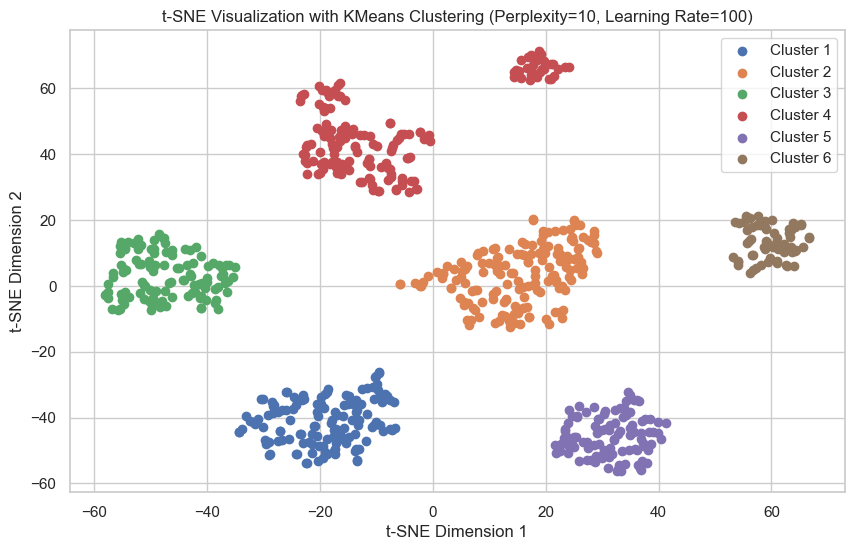

In [114]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Extract the numerical data from combined_df_encoded
# numerical_data = combined_df_encoded.drop(columns=["TeamID", "Loc"])

# # Normalize the numerical data
# scaler = StandardScaler()
# numerical_data_normalized = scaler.fit_transform(numerical_data)

# # Define the parameter values to iterate over
# perplexity = 10
# learning_rate = 100

# # Perform t-SNE with the specified parameters on the normalized data
# tsne = TSNE(
#     n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42
# )
# tsne_results = tsne.fit_transform(numerical_data_normalized)

# # Perform KMeans clustering with 6 clusters on the t-SNE results
# kmeans = KMeans(n_clusters=6, random_state=42)
# cluster_labels = kmeans.fit_predict(tsne_results)

# # Add cluster labels to the original DataFrame
# combined_df_encoded["Cluster"] = cluster_labels

# # Extract rows belonging to each cluster
# cluster_rows = [
#     combined_df_encoded[combined_df_encoded["Cluster"] == cluster]
#     for cluster in range(6)
# ]

# # Plot the t-SNE results with color-coded clusters
# plt.figure(figsize=(10, 6))
# for cluster in range(6):
#     # Filter data points belonging to the current cluster
#     cluster_data = tsne_results[cluster_labels == cluster]

#     # Plot data points for the current cluster
#     plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster+1}")

# plt.title(
#     f"t-SNE Visualization with KMeans Clustering (Perplexity={perplexity}, Learning Rate={learning_rate})"
# )
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.legend()
# plt.show()

# # Now you have individual rows for each cluster that you can further analyze or manipulate

c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

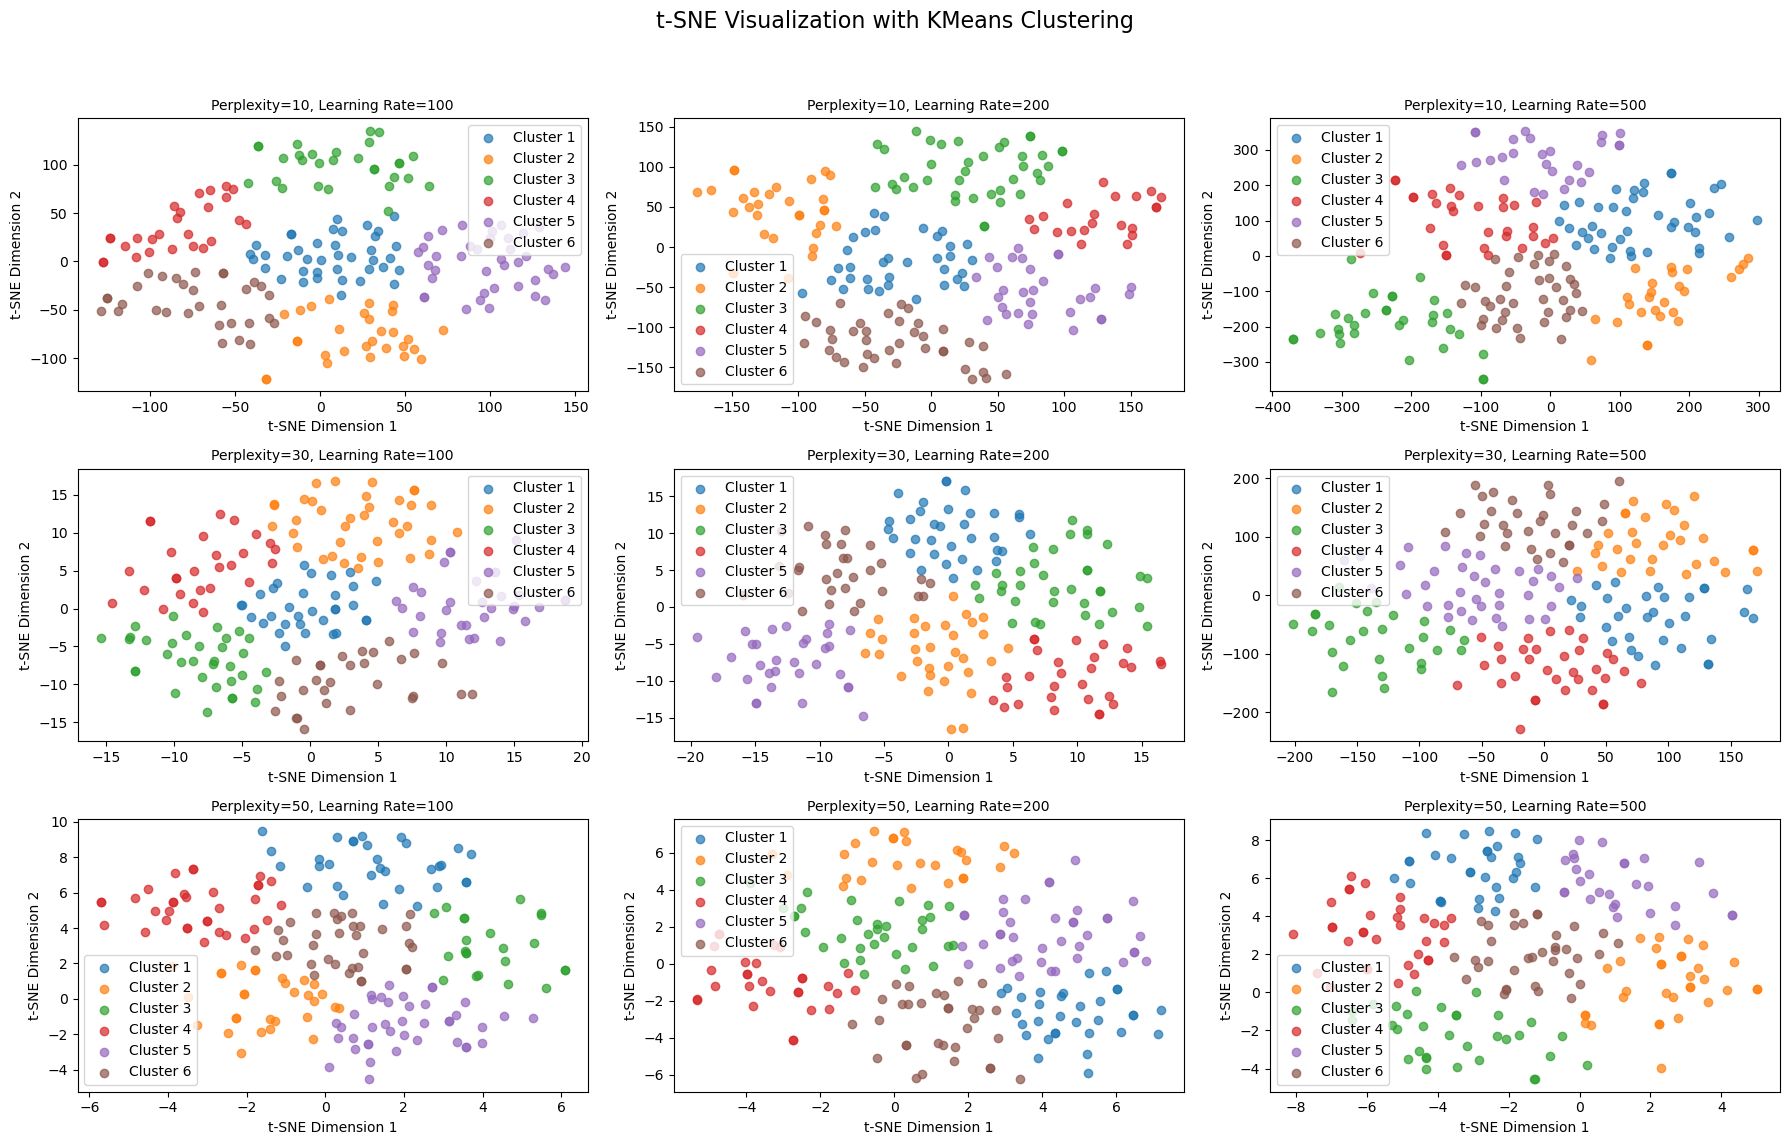

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extract the numerical data from balanced_df
numerical_data = balanced_df.drop(columns=["TeamID", "Loc", "CoachName", "Cluster"])

# Normalize the numerical data
scaler = StandardScaler()
numerical_data_normalized = scaler.fit_transform(numerical_data)

# Define the parameter values to iterate over
perplexities = [10, 30, 50]
learning_rates = [100, 200, 500]

# Plot t-SNE results for different perplexities and learning rates
plt.figure(figsize=(18, 12))

# Iterate over different combinations of perplexity and learning rate
for i, perplexity in enumerate(perplexities):
    for j, learning_rate in enumerate(learning_rates):
        # Perform t-SNE with the specified parameters on the normalized data
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate=learning_rate,
            random_state=42,
        )
        tsne_results = tsne.fit_transform(numerical_data_normalized)

        # Perform KMeans clustering with 6 clusters on the t-SNE results
        kmeans = KMeans(n_clusters=6, random_state=42)
        cluster_labels = kmeans.fit_predict(tsne_results)

        # Add cluster labels to the original DataFrame
        numerical_data["Cluster"] = cluster_labels

        # Extract rows belonging to each cluster
        cluster_rows = [
            numerical_data[numerical_data["Cluster"] == cluster] for cluster in range(6)
        ]

        # Plot t-SNE results with color-coded clusters
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.title(
            f"Perplexity={perplexity}, Learning Rate={learning_rate}", fontsize=10
        )
        for cluster in range(6):
            # Filter data points belonging to the current cluster
            cluster_data = tsne_results[cluster_labels == cluster]

            # Plot data points for the current cluster
            plt.scatter(
                cluster_data[:, 0],
                cluster_data[:, 1],
                label=f"Cluster {cluster + 1}",
                alpha=0.7,
            )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()

plt.suptitle("t-SNE Visualization with KMeans Clustering", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ayush\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


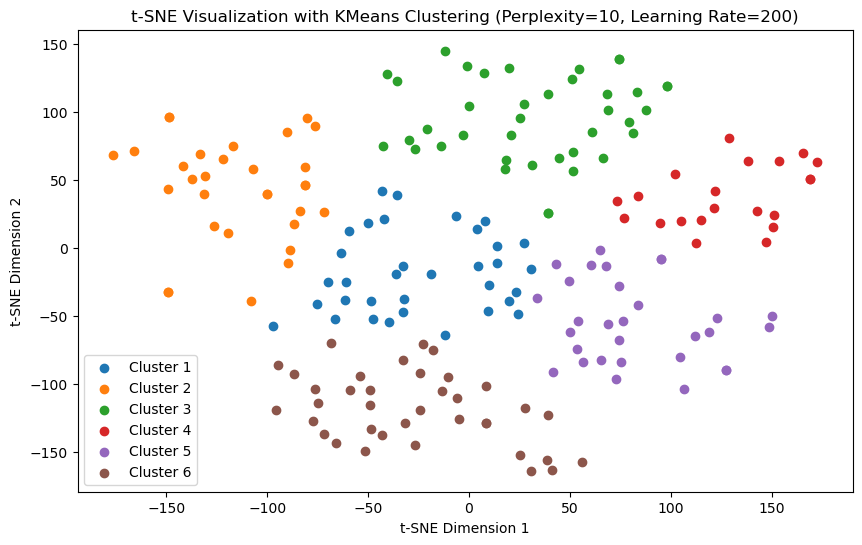

In [46]:
numerical_data = balanced_df.drop(columns=["TeamID", "Loc", "CoachName", "Cluster"])

# Normalize the numerical data
scaler = StandardScaler()
numerical_data_normalized = scaler.fit_transform(numerical_data)

# Define the parameter values to iterate over
perplexity = 10
learning_rate = 200

# Perform t-SNE with the specified parameters on the normalized data
tsne = TSNE(
    n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42
)
tsne_results = tsne.fit_transform(numerical_data_normalized)

# Perform KMeans clustering with 6 clusters on the t-SNE results
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_results)

# Add cluster labels to the original DataFrame
numerical_data["Cluster"] = cluster_labels

# Extract rows belonging to each cluster
cluster_rows = [
    numerical_data[numerical_data["Cluster"] == cluster] for cluster in range(6)
]

# Plot the t-SNE results with color-coded clusters
plt.figure(figsize=(10, 6))
for cluster in range(6):
    # Filter data points belonging to the current cluster
    cluster_data = tsne_results[cluster_labels == cluster]

    # Plot data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster+1}")

plt.title(
    f"t-SNE Visualization with KMeans Clustering (Perplexity={perplexity}, Learning Rate={learning_rate})"
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [47]:
# Access individual cluster rows
cluster_1_rows = cluster_rows[0]
cluster_2_rows = cluster_rows[1]
cluster_3_rows = cluster_rows[2]
cluster_4_rows = cluster_rows[3]
cluster_5_rows = cluster_rows[4]
cluster_6_rows = cluster_rows[5]

In [92]:
cluster_1_rows

,TeamID,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,...,Stl,Blk,PF,archie_miller,dan_dakich,kelvin_sampson,mike_davis,mike_woodson,tom_crean,Cluster
2,1231,70,N,20,49,8,25,22,34,10,...,5,4,23,0.0,0.0,0.0,1.0,0.0,0.0,0
7,1231,66,N,21,56,3,14,21,31,16,...,6,9,18,0.0,0.0,0.0,1.0,0.0,0.0,0
8,1231,64,NaN,20,49,5,17,19,26,10,...,3,9,16,0.0,0.0,0.0,1.0,0.0,0.0,0
12,1231,78,H,28,65,4,17,18,27,15,...,6,6,15,0.0,0.0,0.0,1.0,0.0,0.0,0
16,1231,69,H,21,52,5,17,22,28,10,...,7,7,22,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,1231,69,H,25,63,3,16,16,28,11,...,1,3,12,0.0,0.0,0.0,0.0,1.0,0.0,0
705,1231,74,H,26,60,6,14,16,27,12,...,6,2,18,0.0,0.0,0.0,0.0,1.0,0.0,0
713,1231,72,NaN,27,53,6,18,12,21,5,...,1,5,22,0.0,0.0,0.0,0.0,1.0,0.0,0
716,1231,74,H,29,47,6,14,10,15,4,...,1,7,8,0.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
filtered_results_df = detailed_results_tourney_df[
    detailed_results_tourney_df["DayNum"] == 154
]


filtered_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
63,2003,154,1393,81,1242,78,N,0,30,63,...,20,12,30,26,26,18,18,9,4,16
127,2004,154,1163,82,1210,73,N,0,26,61,...,22,12,21,18,25,9,14,10,1,26
191,2005,154,1314,75,1228,70,N,0,27,52,...,40,4,6,17,22,18,8,8,1,18
255,2006,154,1196,73,1417,57,N,0,26,58,...,17,10,14,14,26,11,12,3,1,22
319,2007,154,1196,84,1326,75,N,0,26,53,...,23,11,17,10,18,10,7,11,4,20
383,2008,154,1242,75,1272,68,N,1,29,55,...,22,12,19,11,17,14,13,11,3,17
447,2009,154,1314,89,1277,72,N,0,28,61,...,23,21,29,13,29,13,21,1,5,28
511,2010,154,1181,61,1139,59,N,0,23,52,...,18,13,18,14,21,7,8,4,0,18
578,2011,154,1163,53,1139,41,N,0,19,55,...,33,8,14,20,21,5,6,8,2,17
645,2012,154,1246,67,1242,59,N,0,23,56,...,11,10,15,11,24,9,9,6,5,16


In [ ]:
filtered_df = pd.DataFrame()

# Iterate over the key-value pairs in row_dict
for key, value in row_dict.items():
    mask = (detailed_results_regular_df["Season"] == key) & (
        (detailed_results_regular_df["WTeamID"] == value)
        | (detailed_results_regular_df["LTeamID"] == value)
    )
    filtered_rows = detailed_results_regular_df[mask]
    filtered_df = pd.concat([filtered_df, filtered_rows])

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

# Home Field Advantage

In [ ]:
detailed_results_regular_df.WLoc.value_counts()

WLoc
H    66598
A    34979
N    11664
Name: count, dtype: int64

In [ ]:
H_count = detailed_results_regular_df[detailed_results_regular_df["WLoc"] == "H"].shape[
    0
]


A_count = detailed_results_regular_df[detailed_results_regular_df["WLoc"] == "A"].shape[
    0
]


total_count = H_count + A_count


percentage_H = (H_count / total_count) * 100
percentage_H

65.56405485493764

There is a 65% chance of winning at home court. 

In [ ]:
percentage_A = (A_count / total_count) * 100
percentage_A

34.43594514506237

There is a 35 % chance of losing in the home court. 